## UPDRS, Age, and Sex Only

From request [UPDRS, Age, and Sex Only](https://trello.com/c/GOGVOO0l)

Run the same Linear SVC Analysis but only use Age, Sex, and UPDRS.  Using the new data set

**NOTE**:  I did not plot the coeficients of the models, but they are listed.

## Imports and Function Definitions

In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [28]:
param_grid = {
    "classifier__C": np.logspace(-5, 2, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_data = _data[['GroupID', 'Age', 'Sex', 'UPDRS']]
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

In [29]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 0.26366508987303555}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89        55
         1.0       0.98      0.93      0.95       146

   micro avg       0.94      0.94      0.94       201
   macro avg       0.91      0.94      0.92       201
weighted avg       0.94      0.94      0.94       201


recall	0.9315068493150684
precision	0.9784172661870504
auc	0.9384806973848069
specificity	0.9454545454545454
npv	0.8387096774193549
accuracy	0.9353233830845771


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [30]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.011398792266845703	0.0007991794043337714
score_time	0.007000875473022461	1.4096971034140094e-06
test_recall	0.956776611694153	0.01442623241838163
train_recall	0.9524248969173374	0.003835067630801343
test_precision	0.9895020489123327	0.01010732197059653
train_precision	0.989226358128761	0.0025877776324531965
test_auc	0.964903457362228	0.00701108180469516
train_auc	0.9627575492056402	0.003446539658362862
test_specificity	0.973030303030303	0.026385880162925174
train_specificity	0.9730902014939427	0.0065423692271858475
test_npv	0.8985331008968883	0.029899825680859447
train_npv	0.8876158026253714	0.007907297801961366
test_accuracy	0.9613188015156842	0.00450016222419838
train_accuracy	0.9581795171339562	0.002992558491983448


In [31]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
# plot_coefficients(model, feature_names, top_features=3)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.2889637798864278
Sex	-0.08041643682329067
UPDRS	3.1138206301685525


              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89        55
         1.0       0.98      0.93      0.95       146

   micro avg       0.94      0.94      0.94       201
   macro avg       0.91      0.94      0.92       201
weighted avg       0.94      0.94      0.94       201



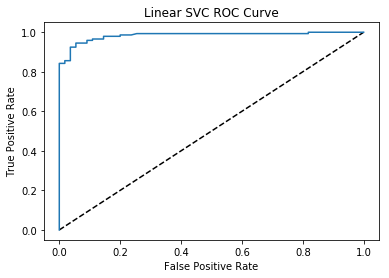

0.0 0.0
0.0 0.0684931506849315
0.0 0.7876712328767124
0.0 0.8013698630136986
0.0 0.8424657534246576
0.01818181818181818 0.8424657534246576
0.01818181818181818 0.8561643835616438
0.03636363636363636 0.8561643835616438
0.03636363636363636 0.8698630136986302
0.03636363636363636 0.8835616438356164
0.03636363636363636 0.9246575342465754
0.05454545454545454 0.9246575342465754
0.05454545454545454 0.9452054794520548
0.09090909090909091 0.9452054794520548
0.09090909090909091 0.958904109589041
0.10909090909090909 0.958904109589041
0.10909090909090909 0.9657534246575342
0.14545454545454545 0.9657534246575342
0.14545454545454545 0.9794520547945206
0.16363636363636364 0.9794520547945206
0.2 0.9794520547945206
0.2 0.9863013698630136
0.23636363636363636 0.9863013698630136
0.2545454545454545 0.9931506849315068
0.6909090909090909 0.9931506849315068
0.7272727272727273 0.9931506849315068
0.8181818181818182 0.9931506849315068
0.8181818181818182 1.0
0.8545454545454545 1.0
0.8727272727272727 1.0
0.909090909

In [32]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [33]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.84      0.66      0.74       105
         1.0       0.43      0.68      0.52        40

   micro avg       0.66      0.66      0.66       145
   macro avg       0.64      0.67      0.63       145
weighted avg       0.73      0.66      0.68       145


recall	0.675
precision	0.42857142857142855
auc	0.6660714285714286
specificity	0.6571428571428571
npv	0.8414634146341463
accuracy	0.6620689655172414


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.019199848175048828	0.005036082149360444
score_time	0.010399723052978515	0.0017442557809827187
test_recall	0.41529411764705876	0.09851435085837831
train_recall	0.4321238661244918	0.10824499326961591
test_precision	0.5500946305156832	0.11057163195483907
train_precision	0.5605471452277654	0.04141865560994606
test_auc	0.6299746709885399	0.042009067138317195
train_auc	0.6415605085608214	0.029769641805045367
test_specificity	0.844655224330021	0.06855174979357405
train_specificity	0.850997150997151	0.05791737324151579
test_npv	0.7735849631508883	0.024673009126600132
train_npv	0.7807435376239746	0.024581265573014738
test_accuracy	0.7165298120170684	0.03952534243510153
train_accuracy	0.7258010326482435	0.016519975491548555


In [35]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
# plot_coefficients(model, feature_names, top_features=3)
print_feature_importance(feature_names, model.coef_[0])

Age	0.1853071637559382
Sex	0.0
UPDRS	0.3559341458899825


              precision    recall  f1-score   support

         0.0       0.84      0.66      0.74       105
         1.0       0.43      0.68      0.52        40

   micro avg       0.66      0.66      0.66       145
   macro avg       0.64      0.67      0.63       145
weighted avg       0.73      0.66      0.68       145



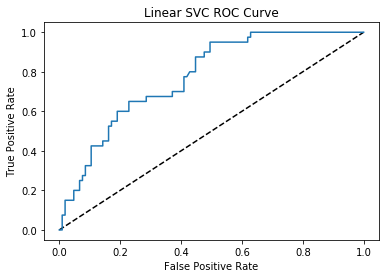

0.0 0.0
0.009523809523809525 0.0
0.009523809523809525 0.075
0.01904761904761905 0.075
0.01904761904761905 0.15
0.047619047619047616 0.15
0.047619047619047616 0.2
0.06666666666666667 0.2
0.06666666666666667 0.25
0.0761904761904762 0.25
0.0761904761904762 0.275
0.08571428571428572 0.275
0.08571428571428572 0.325
0.10476190476190476 0.325
0.10476190476190476 0.425
0.14285714285714285 0.425
0.14285714285714285 0.45
0.1619047619047619 0.45
0.1619047619047619 0.525
0.17142857142857143 0.525
0.17142857142857143 0.55
0.19047619047619047 0.55
0.19047619047619047 0.6
0.22857142857142856 0.6
0.22857142857142856 0.65
0.2857142857142857 0.65
0.2857142857142857 0.675
0.37142857142857144 0.675
0.37142857142857144 0.7
0.4095238095238095 0.7
0.4095238095238095 0.775
0.41904761904761906 0.775
0.42857142857142855 0.8
0.44761904761904764 0.8
0.44761904761904764 0.875
0.47619047619047616 0.875
0.47619047619047616 0.9
0.49523809523809526 0.9
0.49523809523809526 0.95
0.6190476190476191 0.95
0.619047619047619

In [36]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA (positive) vs PSP

In [37]:
# Get the data
data3 = group_classes(_data, {3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 0.04832930238571752}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.70      0.63      0.67        30
         1.0       0.31      0.38      0.34        13

   micro avg       0.56      0.56      0.56        43
   macro avg       0.51      0.51      0.51        43
weighted avg       0.59      0.56      0.57        43


recall	0.38461538461538464
precision	0.3125
auc	0.5089743589743589
specificity	0.6333333333333333
npv	0.7037037037037037
accuracy	0.5581395348837209


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00399932861328125	0.0010948873811170217
score_time	0.008999872207641601	0.004147723641947266
test_recall	0.7314285714285715	0.12434317226850826
train_recall	0.7357769423558896	0.04917792033850198
test_precision	0.6166666666666667	0.10443672475933957
train_precision	0.6198717400639298	0.02779352261106322
test_auc	0.6996616541353384	0.09012419117174
train_auc	0.7062903699121221	0.03013531282054239
test_specificity	0.6678947368421053	0.10521577881099073
train_specificity	0.6768037974683544	0.022887339636894065
test_npv	0.7817645074224021	0.09571096837230078
train_npv	0.7823991290739607	0.034601905978158605
test_accuracy	0.6938680926916222	0.08871903981294191
train_accuracy	0.7014635911136555	0.027794064480391945


In [39]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
# plot_coefficients(model, feature_names, top_features=3)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.5913931227543963
Sex	-0.18840053372026586
UPDRS	0.661648238171064


              precision    recall  f1-score   support

         0.0       0.70      0.63      0.67        30
         1.0       0.31      0.38      0.34        13

   micro avg       0.56      0.56      0.56        43
   macro avg       0.51      0.51      0.51        43
weighted avg       0.59      0.56      0.57        43



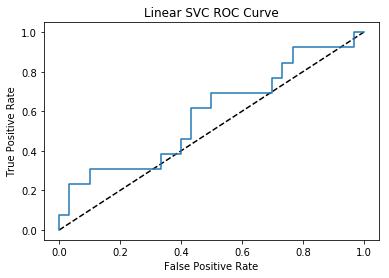

0.0 0.0
0.0 0.07692307692307693
0.03333333333333333 0.07692307692307693
0.03333333333333333 0.23076923076923078
0.1 0.23076923076923078
0.1 0.3076923076923077
0.3333333333333333 0.3076923076923077
0.3333333333333333 0.38461538461538464
0.4 0.38461538461538464
0.4 0.46153846153846156
0.43333333333333335 0.46153846153846156
0.43333333333333335 0.6153846153846154
0.5 0.6153846153846154
0.5 0.6923076923076923
0.7 0.6923076923076923
0.7 0.7692307692307693
0.7333333333333333 0.7692307692307693
0.7333333333333333 0.8461538461538461
0.7666666666666667 0.8461538461538461
0.7666666666666667 0.9230769230769231
0.9666666666666667 0.9230769230769231
0.9666666666666667 1.0
1.0 1.0


In [40]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP (positive) vs MSA

In [41]:
# Get the data
data4 = group_classes(_data, {2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 0.04832930238571752}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.31      0.38      0.34        13
         1.0       0.70      0.63      0.67        30

   micro avg       0.56      0.56      0.56        43
   macro avg       0.51      0.51      0.51        43
weighted avg       0.59      0.56      0.57        43


recall	0.6333333333333333
precision	0.7037037037037037
auc	0.5089743589743589
specificity	0.38461538461538464
npv	0.3125
accuracy	0.5581395348837209


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [42]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.003399229049682617	0.0004889284069753907
score_time	0.005999898910522461	0.0006314296049728742
test_recall	0.6678947368421053	0.10521577881099073
train_recall	0.6768037974683544	0.022887339636894065
test_precision	0.7817645074224021	0.09571096837230078
train_precision	0.7823991290739607	0.034601905978158605
test_auc	0.6996616541353383	0.09012419117174005
train_auc	0.7062903699121221	0.03013531282054237
test_specificity	0.7314285714285715	0.12434317226850826
train_specificity	0.7357769423558896	0.04917792033850198
test_npv	0.6166666666666667	0.10443672475933957
train_npv	0.6198717400639298	0.02779352261106322
test_accuracy	0.6938680926916222	0.08871903981294191
train_accuracy	0.7014635911136555	0.027794064480391945


In [43]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
# plot_coefficients(model, feature_names, top_features=3)
print_feature_importance(feature_names, model.coef_[0])

Age	0.5914559056223176
Sex	0.18763473811474546
UPDRS	-0.6622173193720181


              precision    recall  f1-score   support

         0.0       0.31      0.38      0.34        13
         1.0       0.70      0.63      0.67        30

   micro avg       0.56      0.56      0.56        43
   macro avg       0.51      0.51      0.51        43
weighted avg       0.59      0.56      0.57        43



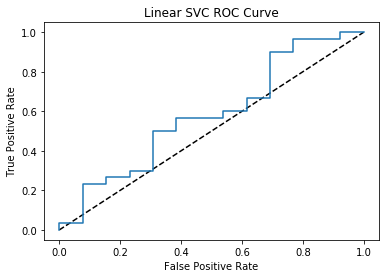

0.0 0.0
0.0 0.03333333333333333
0.07692307692307693 0.03333333333333333
0.07692307692307693 0.23333333333333334
0.15384615384615385 0.23333333333333334
0.15384615384615385 0.26666666666666666
0.23076923076923078 0.26666666666666666
0.23076923076923078 0.3
0.3076923076923077 0.3
0.3076923076923077 0.5
0.38461538461538464 0.5
0.38461538461538464 0.5666666666666667
0.5384615384615384 0.5666666666666667
0.5384615384615384 0.6
0.6153846153846154 0.6
0.6153846153846154 0.6666666666666666
0.6923076923076923 0.6666666666666666
0.6923076923076923 0.9
0.7692307692307693 0.9
0.7692307692307693 0.9666666666666667
0.9230769230769231 0.9666666666666667
0.9230769230769231 1.0
1.0 1.0


In [44]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)